# 1. Import packages and load data

In [1]:
# sys packages
import sys
import os
import torch
import numpy as np
import pandas as pd
from torch import nn
from torch import optim
sys.path.append('../src')


In [2]:
# custom packages
from data_loading import load_data, prepare_dataloader
from data_plotting import plot_protein_family_distribution, plot_sequence_length_distribution, plot_amino_acid_distribution
from seq_encoding import encode_partition_sequences, pad_partition_sequences, one_hot_encode_labels
from model_train import train_model, plot_loss_curve, plot_accuracy_curve
from evaluate import evaluate
from lstm import BiLSTM
from cnn import ResNet

In [19]:
# Import data

pfam_dir = '../data/random_split'

train = load_data(os.path.join(pfam_dir, 'train')) 
dev = load_data(os.path.join(pfam_dir, 'dev'))
test = load_data(os.path.join(pfam_dir, 'test'))

In [7]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [8]:
# print the shape of the data
print("Train shape : ", train.shape)
print("Dev shape : ", dev.shape)
print("Test shape : ", test.shape)

Train shape :  (1086741, 5)
Dev shape :  (126171, 5)
Test shape :  (126171, 5)


In [20]:
# Create a partition of the data
partition = { 'train': train, 'dev': dev, 'test': test }

# 2. Data analysis and visualisation

## 2.1 Protein family distribution

In [5]:
# Plot the protein family distribution

plot_protein_family_distribution(partition, '../analysis')

In [21]:
# Get the families with the most sequences, top 50

top_50_prot_families = train['family_accession'].value_counts().head(50)

# Get new dataframes with only the top 50 protein families

train_top_50 = train[train['family_accession'].isin(top_50_prot_families.index)]
dev_top_50 = dev[dev['family_accession'].isin(top_50_prot_families.index)]
test_top_50 = test[test['family_accession'].isin(top_50_prot_families.index)]

In [12]:
print("Train shape : ", train_top_50.shape)
print("Dev shape : ", dev_top_50.shape)
print("Test shape : ", test_top_50.shape)

Train shape :  (55216, 6)
Dev shape :  (6875, 6)
Test shape :  (6875, 6)


In [22]:
# Create a partition of the data with only the top 50 protein families

partition_top_50 = { 'train': train_top_50, 'dev': dev_top_50, 'test': test_top_50 }

In [13]:
# Plot the protein family distribution for the top 50 protein families

plot_protein_family_distribution(partition_top_50, '../analysis')

## 2.2 Sequence length analysis

In [24]:
# Get the sequence length for each sequence in the dataset
def get_sequence_length(data):
    data = data.copy()
    data['seq_length'] = data['sequence'].apply(lambda x: len(x))
    return data

for key in partition.keys():
    partition[key] = get_sequence_length(partition[key])

for key in partition_top_50.keys():
    partition_top_50[key] = get_sequence_length(partition_top_50[key])

In [26]:
# Compute the sequence length distribution and the maximum sequence length covering 80% of sequences

coverage_threshold = 0.80

def sequence_length_distribution(data, coverage_threshold):
    seq_lengths = data['seq_length'].value_counts().sort_index()
    seq_lengths = seq_lengths.cumsum() / seq_lengths.sum()
    max_seq_length = seq_lengths[seq_lengths < coverage_threshold].index.max()
    return seq_lengths, max_seq_length

seq_lengths, max_seq_length = sequence_length_distribution(train_top_50, coverage_threshold)


print(f"Maximum sequence length covering {coverage_threshold * 100}% of sequences: {max_seq_length}")

Maximum sequence length covering 80.0% of sequences: 183


In [27]:
# plot the sequence length distribution

plot_sequence_length_distribution(partition, '../analysis')

## 2.3 Amino acid frequency analysis

In [28]:
# plot the amino acid distribution

plot_amino_acid_distribution(partition, 'train', '../analysis/amino_acid_count_train.png')

## 2.4 Data table summary

In [52]:
# Generate a table of the information for each dataset in the partition, including data size, relative ratio (vs total data), number of unique families, 
# average number of sequences per family, maximum number of sequences per family, average sequence length, maximum sequence length and missing values.

def data_info(partition):
    total_data = pd.concat(partition.values())
    data_info = {}
    for key in partition.keys():
        data = partition[key]
        data_info[key] = {
            'data_size': data.shape[0],
            'relative_ratio': data.shape[0] / total_data.shape[0],
            'unique_families': len(data['family_accession'].unique()),
            'avg_seq_per_family': data.shape[0] / len(data['family_accession'].unique()),
            'max_seq_per_family': data['family_accession'].value_counts().max(),
            'avg_seq_length': data['seq_length'].mean(),
            'max_seq_length': data['seq_length'].max(),
            'missing_values': data.isnull().sum().sum()
        }

    # save the table as a csv file
    pd.DataFrame(data_info).T.to_csv('../analysis/data_info.csv')

    return pd.DataFrame(data_info).T

data_info(partition)

,data_size,relative_ratio,unique_families,avg_seq_per_family,max_seq_per_family,avg_seq_length,max_seq_length,missing_values
train,1086741.0,0.811556,17929.0,60.613587,3637.0,155.379971,2037.0,0.0
dev,126171.0,0.094222,13071.0,9.652743,454.0,154.222206,1971.0,0.0
test,126171.0,0.094222,13071.0,9.652743,454.0,154.166845,1937.0,0.0


# 3. Data preparation for training

In [29]:
# Encode the sequences

encoded_partition_top_50 = encode_partition_sequences(partition_top_50, max_seq_length)


In [30]:
# Pad the sequences
x_train_top50, x_dev_top50, x_test_top50 = pad_partition_sequences(encoded_partition_top_50)

In [31]:
# One hot encode the labels
y_train_top50, y_dev_top50, y_test_top50 = one_hot_encode_labels(partition_top_50, column='family_accession')

/home/barry/anaconda3/envs/pfam/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/barry/anaconda3/envs/pfam/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/barry/anaconda3/envs/pfam/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [32]:
# Prepare the dataloaders
lstm_train_loader = prepare_dataloader(x_train_top50, y_train_top50, batch_size=256, dtype_x=torch.int64)
lstm_dev_loader = prepare_dataloader(x_dev_top50, y_dev_top50, batch_size=256, dtype_x=torch.int64)
lstm_test_loader = prepare_dataloader(x_test_top50, y_test_top50, batch_size=256, dtype_x=torch.int64)

/mnt/e/Users/barry/Local_assignment/pfam_test/notebook/../src/data_loading.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(x, dtype=dtype_x), y_class_indices)


In [15]:
def check_data_shapes_and_labels(dataloader):
    for inputs, labels in dataloader:
        print(f'Inputs shape: {inputs.shape}')
        print(f'Labels shape: {labels.shape}')
        print(f'Labels unique values: {torch.unique(labels)}')
        break

# Check train loader
check_data_shapes_and_labels(lstm_train_loader)


Inputs shape: torch.Size([256, 183])
Labels shape: torch.Size([256])
Labels unique values: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])


# 4. Model Training

## 4.1 Bidirectional LSTM

In [33]:
# Train the LSTM model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = BiLSTM(vocab_size = 25, num_classes=50, embedding_dim=256, dropout_rate=0.2).to(device)
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [34]:
# Train the model and record the training history

trained_lstm_model, history = train_model(lstm_model, lstm_train_loader, lstm_dev_loader, criterion, optimizer, num_epochs=200)


Epoch [1/200], Train Loss: 3.8255, Train Acc: 0.1236, Val Loss: 3.7663, Val Acc: 0.1853, Time: 2.27s
Epoch [2/200], Train Loss: 3.6747, Train Acc: 0.2817, Val Loss: 3.6176, Val Acc: 0.3293, Time: 4.15s
Epoch [3/200], Train Loss: 3.6116, Train Acc: 0.3398, Val Loss: 3.5744, Val Acc: 0.3744, Time: 6.02s
Epoch [4/200], Train Loss: 3.5553, Train Acc: 0.3972, Val Loss: 3.5301, Val Acc: 0.4164, Time: 7.88s
Epoch [5/200], Train Loss: 3.5351, Train Acc: 0.4131, Val Loss: 3.5300, Val Acc: 0.4151, Time: 9.73s
Epoch [6/200], Train Loss: 3.5171, Train Acc: 0.4329, Val Loss: 3.4958, Val Acc: 0.4508, Time: 11.59s
Epoch [7/200], Train Loss: 3.4986, Train Acc: 0.4506, Val Loss: 3.4893, Val Acc: 0.4560, Time: 13.45s
Epoch [8/200], Train Loss: 3.4802, Train Acc: 0.4697, Val Loss: 3.4577, Val Acc: 0.4890, Time: 15.50s
Epoch [9/200], Train Loss: 3.4488, Train Acc: 0.5038, Val Loss: 3.4151, Val Acc: 0.5337, Time: 17.35s
Epoch [10/200], Train Loss: 3.4212, Train Acc: 0.5298, Val Loss: 3.3978, Val Acc: 0.551

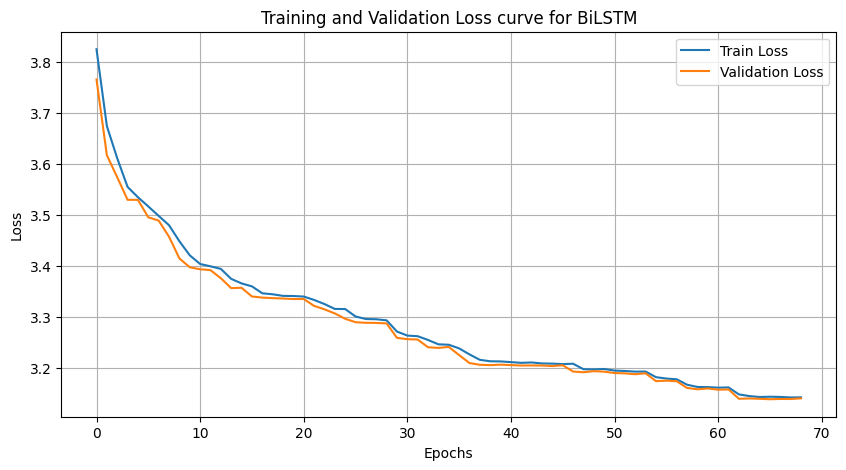

In [37]:
# Plot the loss curve
plot_loss_curve(history, '../analysis/lstm_vocab_25_69epoch_loss_curve.png', 'BiLSTM')	

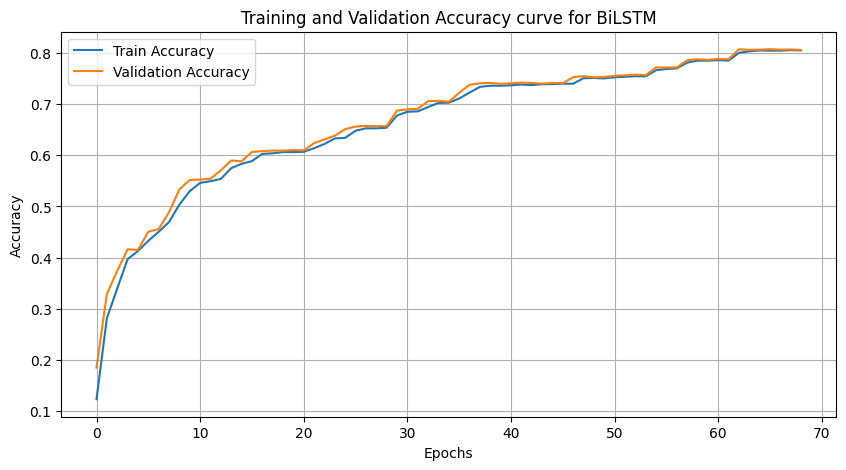

In [38]:
# Plot the accuracy curve
plot_accuracy_curve(history, '../analysis/lstm_vocab_25_69epoch_acc_curve.png', 'BiLSTM')

In [39]:
# save the model
model_save_path = '../models/lstm_vocab_25_69epoch.pt'
torch.save(trained_lstm_model.state_dict(), model_save_path)

In [40]:
# convert history to dataframe
history_df = pd.DataFrame(history)
# save history in a csv file
history_save_path = '../analysis/lstm_vocab_25_69epoch_history.csv'
history_df.to_csv(history_save_path, index=False)

In [43]:
# evaluate the model
lstm_train_metrics = evaluate(trained_lstm_model, lstm_train_loader, criterion)

Test Loss: 3.1357, Test Accuracy: 0.8103


## 4.2 ProtCNN

In [44]:
# prepare dataloader for Pytorch

train_loader = prepare_dataloader(x_train_top50, y_train_top50, batch_size=256, dtype_x=torch.float32)
dev_loader = prepare_dataloader(x_dev_top50, y_dev_top50, batch_size=256, dtype_x=torch.float32)
test_loader = prepare_dataloader(x_test_top50, y_test_top50, batch_size=256, dtype_x=torch.float32)

/mnt/e/Users/barry/Local_assignment/pfam_test/notebook/../src/data_loading.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dataset = TensorDataset(torch.tensor(x, dtype=dtype_x), y_class_indices)


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet_model = ResNet(input_size=max_seq_length, num_classes=50, num_blocks=[3, 4, 6, 3], dropout_rate = 0.2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.parameters(), lr=0.001, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [46]:
trained_resnet_model, resnet_history = train_model(resnet_model, train_loader, dev_loader, criterion, optimizer, num_epochs=50)

Epoch [1/50], Train Loss: 1.4790, Train Acc: 0.5595, Val Loss: 0.8165, Val Acc: 0.7527, Time: 5.43s
Epoch [2/50], Train Loss: 0.6968, Train Acc: 0.7957, Val Loss: 0.5567, Val Acc: 0.8374, Time: 10.11s
Epoch [3/50], Train Loss: 0.5143, Train Acc: 0.8542, Val Loss: 0.4884, Val Acc: 0.8612, Time: 14.90s
Epoch [4/50], Train Loss: 0.4456, Train Acc: 0.8747, Val Loss: 0.4119, Val Acc: 0.8803, Time: 19.60s
Epoch [5/50], Train Loss: 0.3890, Train Acc: 0.8892, Val Loss: 0.3856, Val Acc: 0.8918, Time: 24.33s
Epoch [6/50], Train Loss: 0.3493, Train Acc: 0.9004, Val Loss: 0.3524, Val Acc: 0.9031, Time: 29.03s
Epoch [7/50], Train Loss: 0.3229, Train Acc: 0.9081, Val Loss: 0.4461, Val Acc: 0.8755, Time: 33.75s
Epoch [8/50], Train Loss: 0.3255, Train Acc: 0.9085, Val Loss: 0.3669, Val Acc: 0.8940, Time: 38.45s
Epoch [9/50], Train Loss: 0.2921, Train Acc: 0.9160, Val Loss: 0.3642, Val Acc: 0.8996, Time: 43.41s
Early stopping at epoch 9


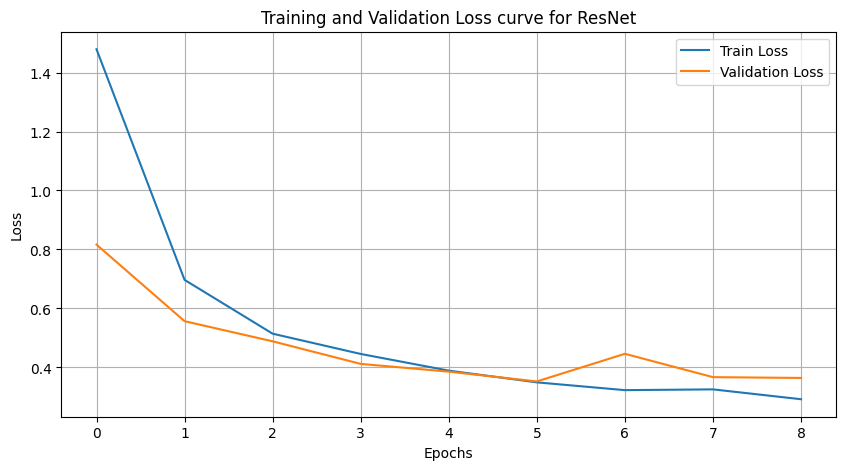

In [47]:
# plot the loss curve
plot_loss_curve(resnet_history, '../analysis/resnet_9epoch_loss.png', 'ResNet')

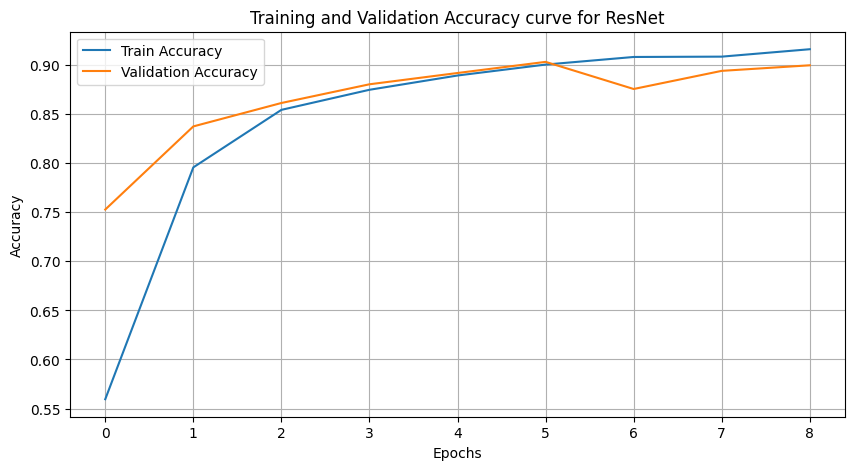

In [48]:
# plot the accuracy curve
plot_accuracy_curve(resnet_history, '../analysis/resnet_9epoch_accuracy.png', 'ResNet')

In [49]:
# save the model
model_save_path = '../models/resnet_9epoch.pt'
torch.save(trained_resnet_model.state_dict(), model_save_path)

In [50]:
# convert history to dataframe
resnet_history_df = pd.DataFrame(resnet_history)
# save history in a csv file
history_save_path = '../analysis/resnet_9epoch_history.csv'
resnet_history_df.to_csv(history_save_path, index=False)

In [51]:
# Evaluate the model

resnet_train_metrics = evaluate(trained_resnet_model, train_loader, criterion)

Test Loss: 0.2632, Test Accuracy: 0.9225
